# Reconstruct empirical PSF

This notebook details how to reconstruct the JWST Point Spread Function (PSF) using stars in the field of view. We will use F200W observation already drizzled to 40mas/pixel. Ideally, this notebook could be run before the drizzling, but we will reconstruct the effective PSF, after drizzling.

By [Martin Millon](https://martin-millon.gitlab.io), February 2023.

In [1]:
# Parameters
subsampling_factor = 2

lambda_scales = 3.
lambda_hf = 3.
lambda_positivity = 1000. #penalising term if the full psf have negative pixels
include_moffat = True
regularize_full_psf = False #If True, regularise [m(x)+b(x)]. Regularise only the b(x) if False.
elliptical = True # if you want to fit ellitpical moffat or simply circular 

noise_maps_type = 'rms' # 'empirical' or 'iweight_maps' or 'rms' (recommended)
use_masks = True

band = 'f200w'
mas = '40mas'
optim_method = 'adabelief'

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.io import fits

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.optim.optimization import Optimizer
from starred.psf.parameters import ParametersPSF
from starred.plots import plot_function as pltf
from starred.utils.noise_utils import propagate_noise
import pyregion


from jax.config import config; config.update("jax_enable_x64", True) #we require double digit precision

### Setup model parameters

In [3]:
data_path = os.path.join(band, 'stars',  mas)
mask_path = os.path.join('masks')
simname = 'reconstruction_ada_subsampling_%s_posi_MC_%2.2f_%2.2f'%(noise_maps_type, lambda_scales, lambda_hf)
outpath = os.path.join(band, 'PSF_reconstruction', simname + '_%i'%subsampling_factor)
if not os.path.isdir(outpath):
    os.makedirs(outpath, exist_ok = True)

convolution_method = 'scipy' #choose 'fft' for a faster implementation on CPU if your version of jax is < 0.4.9, 'scipy' is the fastest on the most recent version of jax


### Retrieve and renormalise the data, estimate noise maps.

In [4]:
# Data 
file_paths = sorted(glob.glob(os.path.join(data_path, 'star*.fits')))
new_vignets_data = np.array([fits.open(f)[0].data for f in file_paths])
headers = np.array([fits.open(f)[0].header for f in file_paths])
N_init = len(file_paths) # number of stars

image_size = np.shape(new_vignets_data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

# Noise map estimation
if noise_maps_type == 'empirical':
    sigma_2 = np.zeros((N, image_size, image_size))
    sigma_sky_2 = np.array([np.std(new_vignets_data[i,int(0.9*image_size):,int(0.9*image_size):]) for i in range(N)]) ** 2
    for i in range(N_init):
        sigma_2[i,:,:] = sigma_sky_2[i] + new_vignets_data[i,:,:].clip(min=0)
elif noise_maps_type ==  'iweight_maps' : 
    file_paths = sorted(glob.glob(os.path.join(data_path, 'iweight_maps_*.fits')))
    sigma_2 =  np.array([fits.open(f)[0].data**2 for f in file_paths]) 
elif noise_maps_type ==  'rms' : 
    file_paths = sorted(glob.glob(os.path.join(data_path, 'rms_maps_*.fits')))
    sigma_2 =  np.array([fits.open(f)[0].data**2 for f in file_paths]) 
else:
    raise ValueError(noise_maps_type)

### Add masks (optional)
Masks can be generated with the 'region' function of DS9 and then save as *.reg files

In [5]:
#Masks (DS( region has to be saved with the "Detector" option))
masks = np.ones((N_init, image_size, image_size))
if use_masks: 
    for i in range(N_init):
        possiblemaskfilepath = os.path.join(mask_path, 'mask_%s.reg'%str(i))
        if os.path.exists(possiblemaskfilepath):
            print('Using mask %s for star %i !'%(possiblemaskfilepath, i+1))
            r = pyregion.open(possiblemaskfilepath)
            masks[i, :, :] =  1 - r.get_mask(shape=(image_size, image_size), header=headers[i]).astype(float)

        #mask central pixel if they are saturated
        ind = np.where(new_vignets_data[i, : ,: ] <= 0)
        for j in range(len(ind[0][:])):
            x,y = ind[0][j], ind[1][j]
            if image_size/2 - 4 < x < image_size/2 + 4 and image_size/2 - 4 < y < image_size/2 + 4: 
                print(f'Central pixel {x}, {y} saturated for star {i+1}.')
                masks[i, x, y] = 0

        print(f'Masking a total of {image_size**2 - masks[i].sum()} pixels for star {i+1}.')


Masking a total of 0.0 pixels for star 1.
Central pixel 30, 30 saturated for star 2.
Central pixel 31, 29 saturated for star 2.
Central pixel 31, 30 saturated for star 2.
Central pixel 31, 31 saturated for star 2.
Masking a total of 4.0 pixels for star 2.
Masking a total of 0.0 pixels for star 3.
Masking a total of 0.0 pixels for star 4.
Central pixel 32, 29 saturated for star 5.
Central pixel 32, 30 saturated for star 5.
Central pixel 33, 29 saturated for star 5.
Masking a total of 3.0 pixels for star 5.
Masking a total of 0.0 pixels for star 6.


In [6]:
#remove stars (1 and 4 have saturated pixels, just masking them is not sufficient...)
remove = [1,4]
new_data = [] 
new_sigma2 = [] 
new_masks = [] 
for i in range(N_init):
    if i not in remove: 
        new_data.append(new_vignets_data[i])
        new_sigma2.append(sigma_2[i])
        new_masks.append(masks[i])

new_data = np.asarray(new_data)
new_sigma2 = np.asarray(new_sigma2)
new_masks = np.asarray(new_masks)
print(f'Removing {len(remove)} stars.')
N = len(new_data[:,0,0])
print('N star :', N)

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = new_data[0].max() / 100.
new_data /= norm
new_sigma2 /= norm**2

#Check that there is no inf value in the noise maps:
for i in range(N):
    ind = np.where(new_sigma2[i,:,:] == np.inf)
    for j,k in zip(ind[0], ind[1]): 
        new_sigma2[i,j,k] = 10*np.mean(np.ma.masked_invalid(new_sigma2[i,:,:]))



Removing 2 stars.
N star : 4


We will now remove 2 stars, which have a saturated pixel in the center.

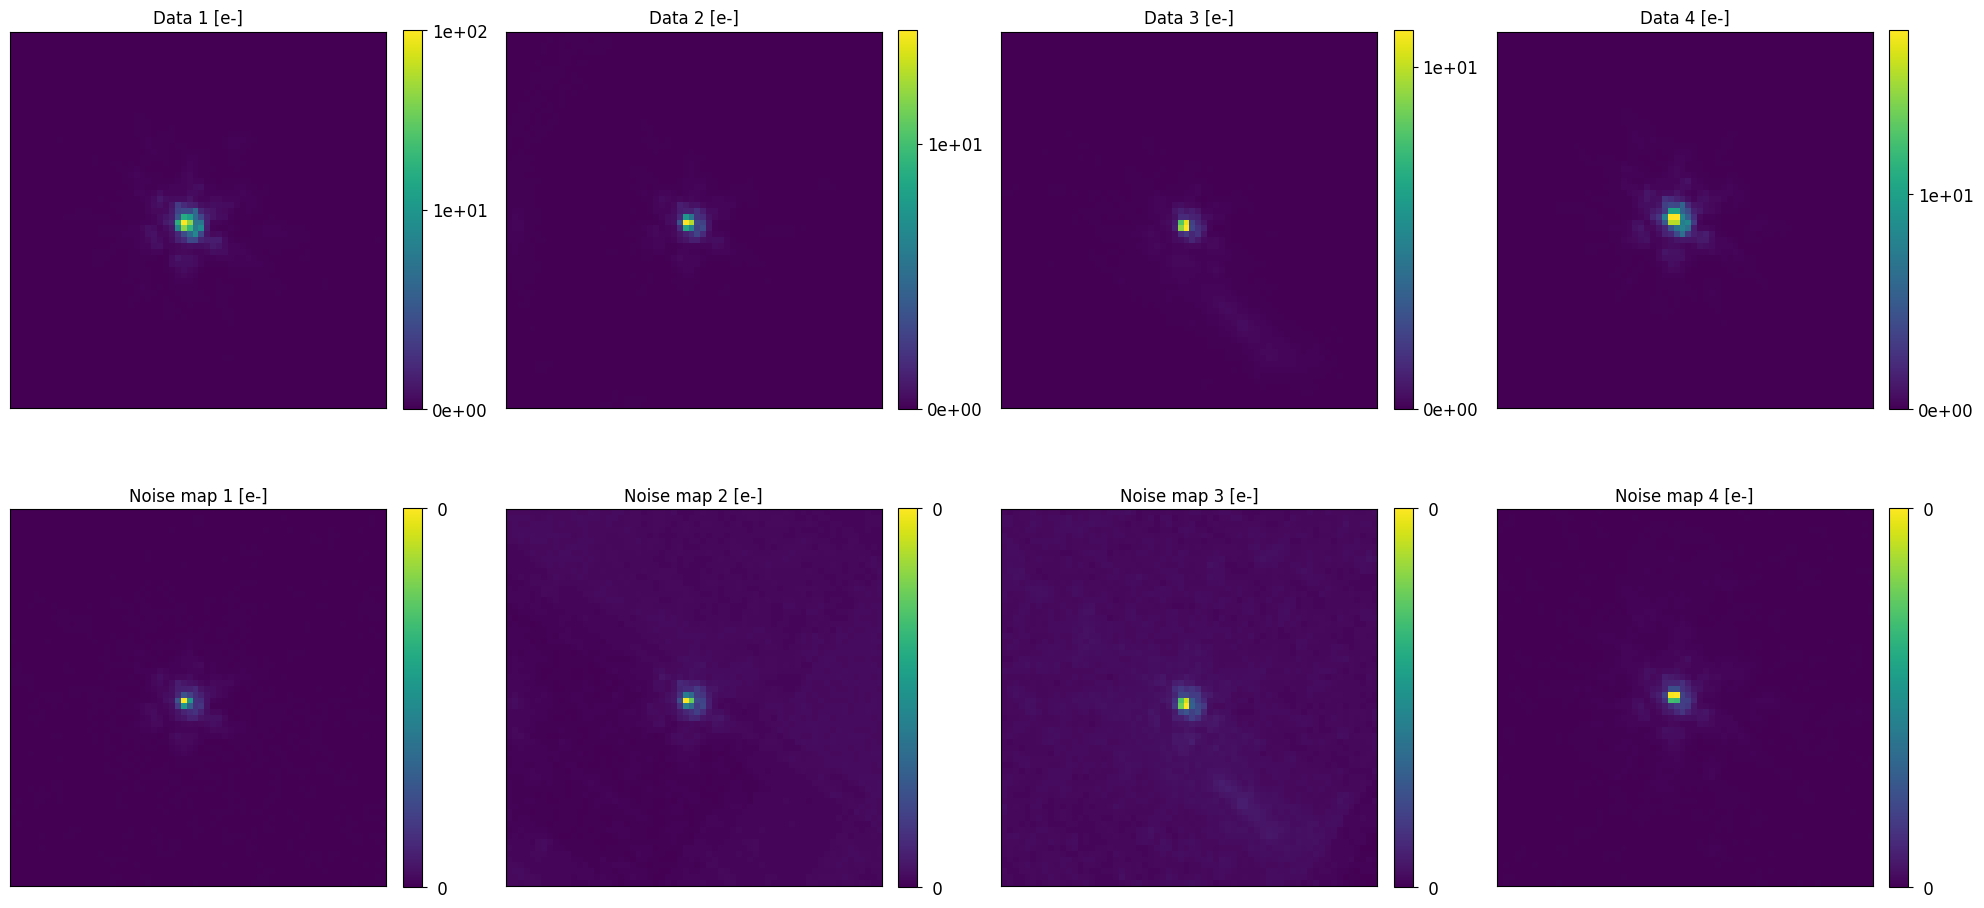

In [7]:
fig=pltf.display_data(new_data, sigma_2=new_sigma2, masks=new_masks, units='e-')

In [8]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat = include_moffat,
            elliptical_moffat = elliptical)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(new_data, fixed_background=True, guess_method='barycenter')
#reset the position to 0 as the JWST is too complex for barycentric estimates
kwargs_init['kwargs_gaussian']['x0'] = np.array([0. for i in range(N)])
kwargs_init['kwargs_gaussian']['y0'] = np.array([0. for i in range(N)])

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

/home/users/millon/modules/starred/starred/psf/psf.py:90: UserWarning: WARNING : jax.scipy has no FFT implementation for the moment. It might be faster to use 'fft' on CPU.
  warnings.warn("WARNING : jax.scipy has no FFT implementation for the moment. It might be faster to use 'fft' on CPU.")


Initial Guess : {'kwargs_moffat': {'fwhm_x': 3.0, 'fwhm_y': 3.0, 'phi': 0.0, 'beta': 2.0, 'C': 21.058484436377185}, 'kwargs_gaussian': {'a': Array([33.18653225, 11.88569183,  7.27848314, 31.88323368], dtype=float64), 'x0': array([0., 0., 0., 0.]), 'y0': array([0., 0., 0., 0.])}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


# Analytical Fit 
We first fit an analytical model (a Moffat function) to speed-up the convergence. We will refine the fit later with a regularized grid of pixels.

In [9]:
# Moffat fitting and amplitude tunning 
loss = Loss(new_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet', 
            regularization_strength_scales=0, regularization_strength_hf=0, masks = new_masks) 
optim = Optimizer(loss, parameters, method=optim_method)

if optim_method == 'l-bfgs-b':
    optimiser_options = {'maxiter':1000, 
                        'restart_from_init':True}
else: 
    optimiser_options = {
                    'max_iterations': 300, 'min_iterations': None,
                    'init_learning_rate': 1e-1, 'schedule_learning_rate': True,
                    'restart_from_init': False, 'stop_at_loss_increase': False,
                    'progress_bar': True, 'return_param_history': True
                }

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_options)

optax.adabelief:   0%|          | 0/300 [00:00<?, ?it/s]/home/users/millon/.local/lib/python3.9/site-packages/jax/_src/scipy/signal.py:78: UserWarning: convolve() ignores method argument
  warnings.warn("convolve() ignores method argument")
optax.adabelief: 100%|██████████| 300/300 [00:04<00:00, 73.17it/s] 


Moffat fit : {'kwargs_moffat': {'fwhm_x': Array([1.61260323], dtype=float64), 'fwhm_y': Array([1.75001015], dtype=float64), 'phi': Array([-2.51777214], dtype=float64), 'beta': Array([10.92693617], dtype=float64), 'C': Array([21.05849363], dtype=float64)}, 'kwargs_gaussian': {'a': Array([ 36.8547222 ,   8.6005314 ,  16.30011608, 100.06955551], dtype=float64), 'x0': Array([-2.04899806,  0.764017  , -0.78762651, -1.95288273], dtype=float64), 'y0': Array([-0.6885657 , -1.11942664, -1.02215961,  0.1887738 ], dtype=float64)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


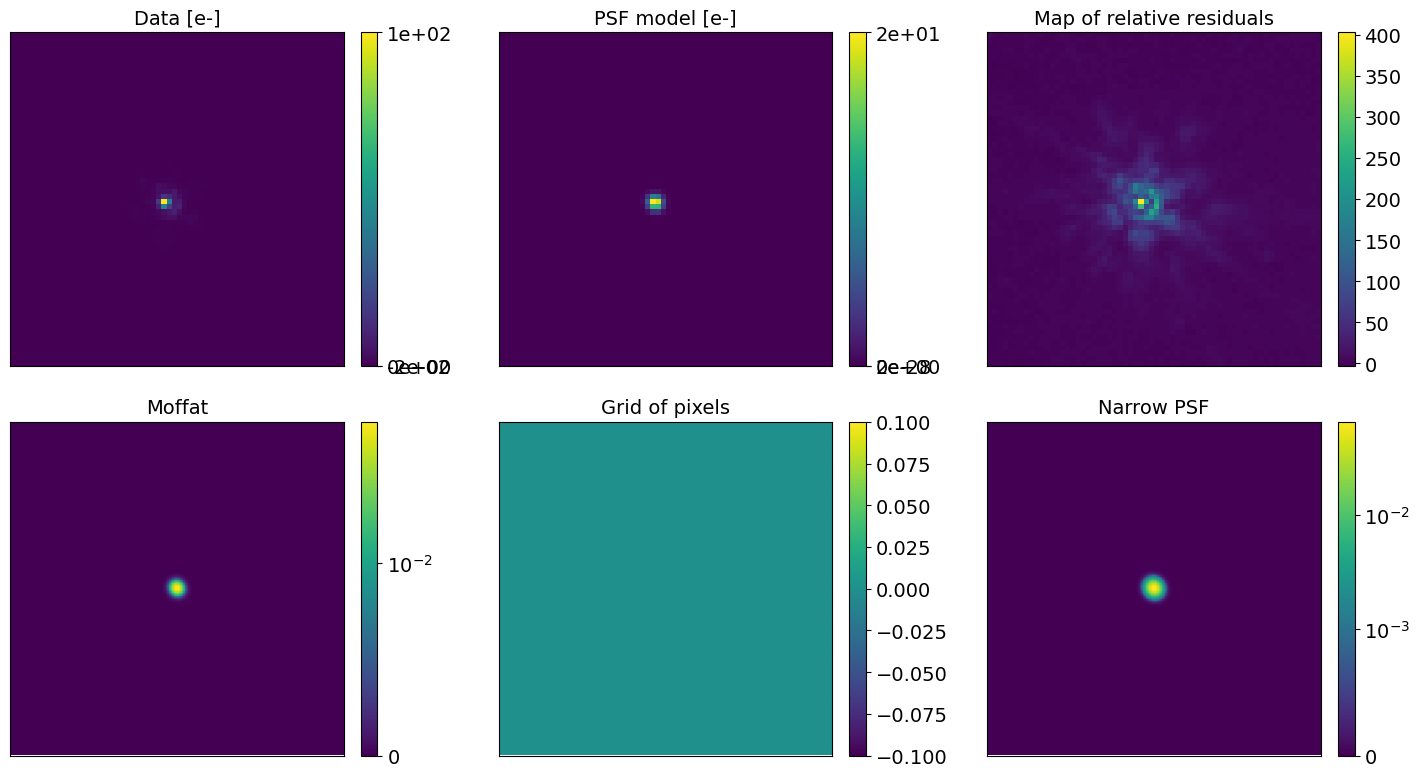

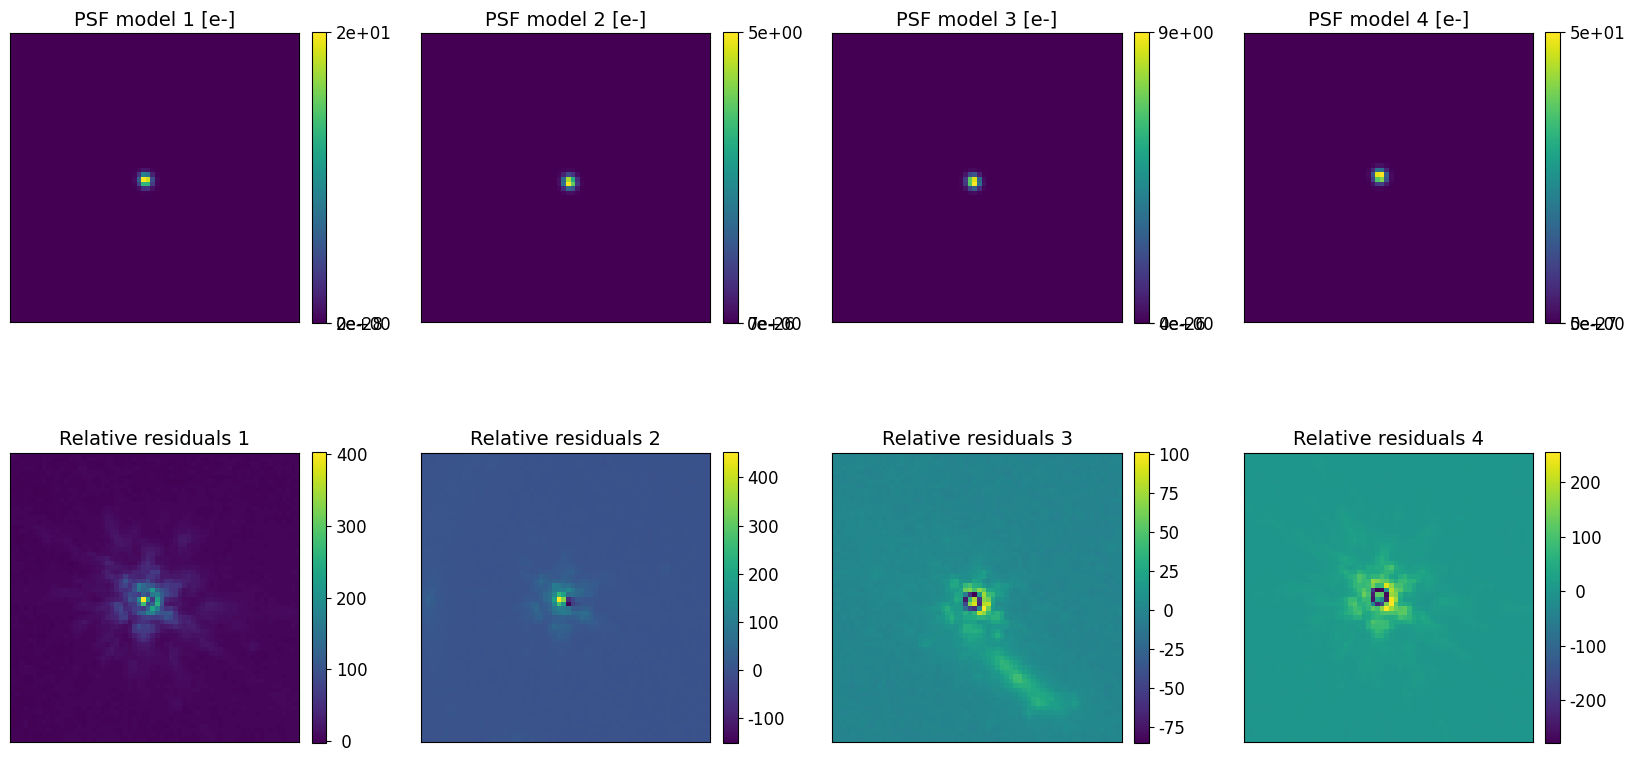

In [10]:
# Printing partial results
kwargs_partial = parameters.args2kwargs(best_fit)
print('Moffat fit :',kwargs_partial) 

fig2 = pltf.single_PSF_plot(model, new_data, new_sigma2, kwargs_partial, n_psf=0, units='e-')
fig3 = pltf.multiple_PSF_plot(model, new_data, new_sigma2, kwargs_partial,masks=new_masks, units='e-')

fig3.savefig(os.path.join(outpath, 'Moffat_fit.png'))

## Noise propagation 
We use this rough model to compute the Poisson noise progation in starlet space. This allows us to adjust the weight, W, and interpret `lambda_hf` and `lambda_scale` in unit of noise. 

/home/users/millon/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


59.878463939103185
46.79285406809069
26.863731137632332
13.774336861661139
6.712807438098533
3.1593732216039427
1.3918861518744925
0.6186320675422684


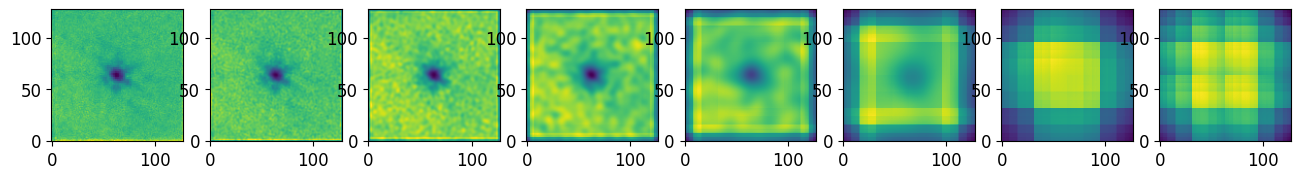

In [11]:
# compute noise level in starlet space, also propagate poisson noise
W = propagate_noise(model, np.sqrt(new_sigma2), kwargs_partial, masks=new_masks, wavelet_type_list=['starlet'], method='MC', num_samples=500,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor, scaling_noise_ref = None)[0]

#This is a representation of your noise level (background + Poisson) in the different starlet scales
gix, axs = plt.subplots(1, len(W), figsize=(16, 4))
for i, l in enumerate(W):
    axs[i].imshow(l, origin='lower')
    print(np.mean(l))
plt.show()
# You can save these noise maps to avoid recomputation
#np.save('./input/W_SLIT_chi2.npy', W)

# Run the full model
Now that our noise level is calibrated, we will also optimise the regularized grid. This time we need an optimiser that can handle a large number of free parameters : `adabelief`

In [12]:
# Release backgound, fix the moffat amplitude
kwargs_moffat_fixed = {'C':kwargs_partial['kwargs_moffat']['C']}

kwargs_fixed = {
    'kwargs_moffat': kwargs_moffat_fixed,
    'kwargs_gaussian': {},
    'kwargs_background': {},
}

parameters = ParametersPSF(kwargs_partial, kwargs_fixed, kwargs_up, kwargs_down)

loss = Loss(new_data, model, parameters, new_sigma2, N, regularization_terms='l1_starlet',
            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
            regularization_strength_positivity=lambda_positivity, W=W, regularize_full_psf=regularize_full_psf, masks=new_masks)


optim = Optimizer(loss, parameters, method='adabelief')

kwargs_optim = {
                'max_iterations': 3000, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'restart_from_init': False, 'stop_at_loss_increase': False,
                'progress_bar': True, 'return_param_history': True
            }
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**kwargs_optim)

optax.adabelief: 100%|██████████| 3000/3000 [00:16<00:00, 185.12it/s]


{'kwargs_moffat': {'fwhm_x': Array([1.33640915], dtype=float64), 'fwhm_y': Array([1.61828647], dtype=float64), 'phi': Array([-2.15233669], dtype=float64), 'beta': Array([1.44529659], dtype=float64), 'C': Array([21.05849363], dtype=float64)}, 'kwargs_gaussian': {'a': Array([86.08717114, 28.42320194, 16.8153966 , 85.38141221], dtype=float64), 'x0': Array([-2.17571157, -1.04050834, -0.7296735 , -1.91478785], dtype=float64), 'y0': Array([-0.7075716 , -0.56000966, -1.07517937,  0.14316713], dtype=float64)}, 'kwargs_background': {'background': Array([ 0.00101437, -0.000145  , -0.00109501, ...,  0.00343237,
        0.00561637,  0.00515708], dtype=float64)}}


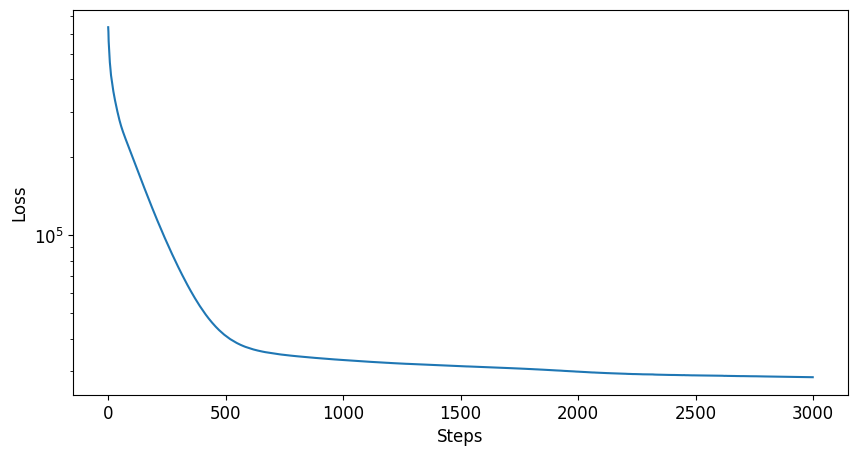

In [13]:
fig_loss = pltf.plot_loss(extra_fields['loss_history'])

kwargs_final = parameters.args2kwargs(best_fit)
fig_loss.savefig(os.path.join(outpath, 'loss.png'))
print(kwargs_final)

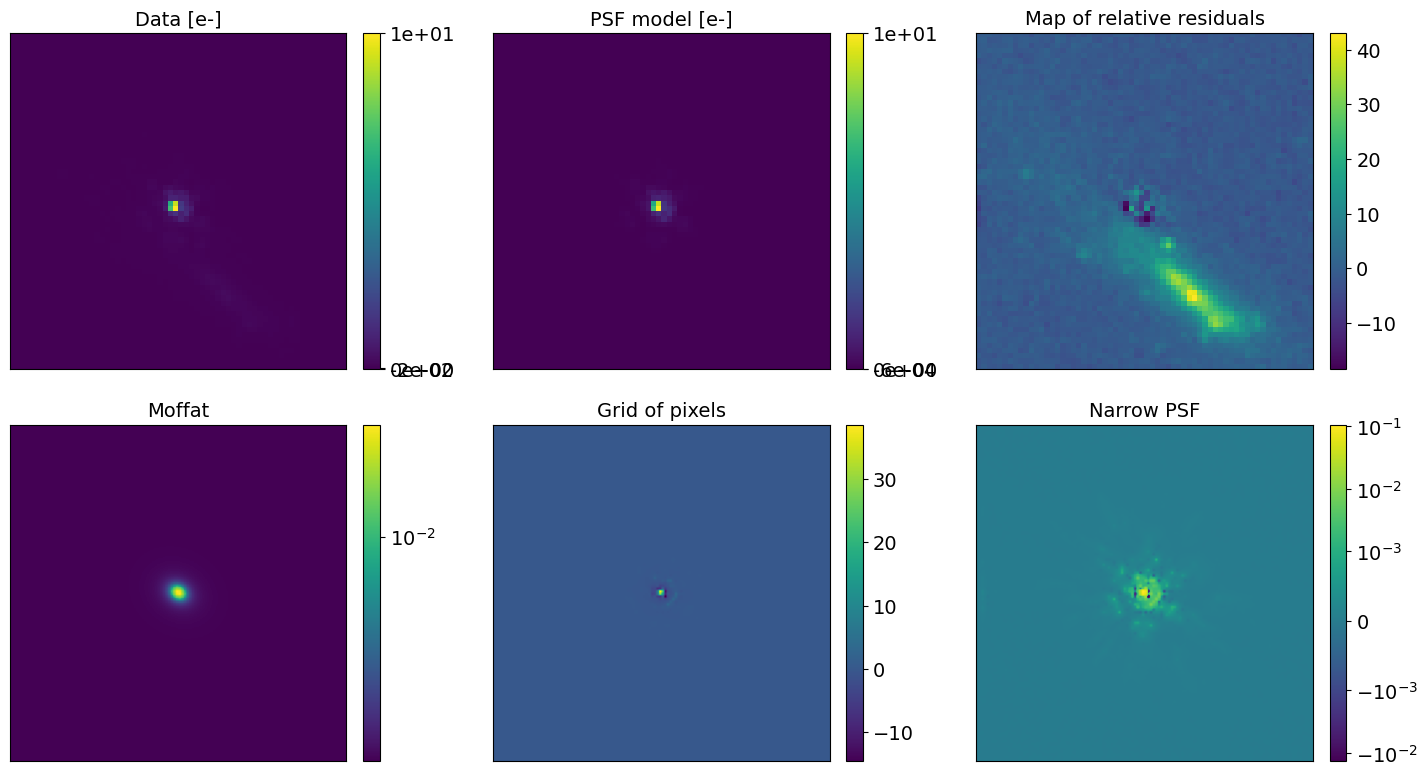

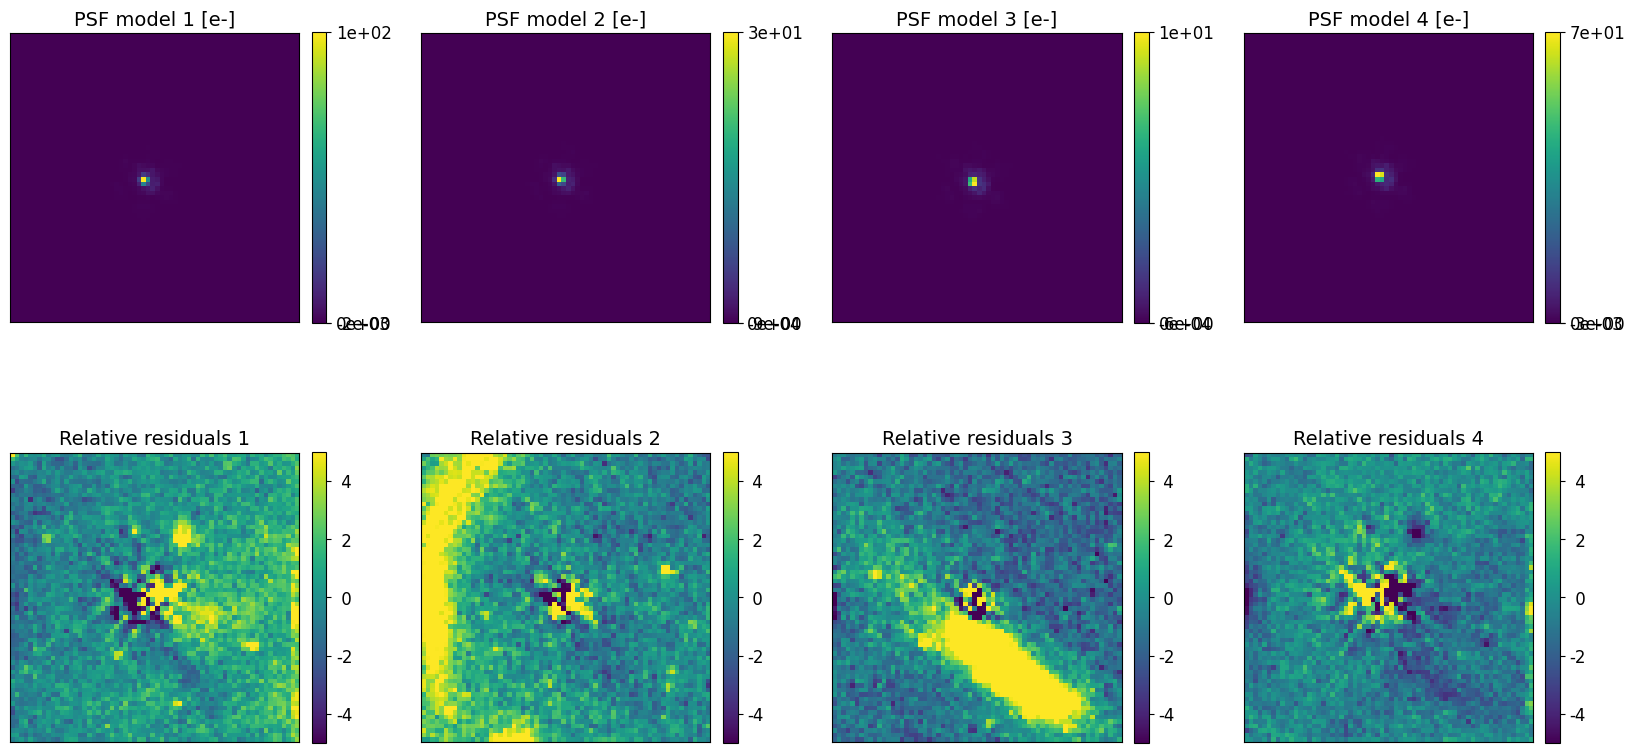

In [14]:
fig4 = pltf.single_PSF_plot(model, new_data, new_sigma2, kwargs_final, masks=new_masks, n_psf=2, units='e-')
fig5 = pltf.multiple_PSF_plot(model, new_data, new_sigma2, kwargs_final, masks=new_masks, units='e-', vmin=-5, vmax=5)

fig4.savefig(os.path.join(outpath, 'model_psf2.png'))
fig5.savefig(os.path.join(outpath, 'model_psfall.png'))

/tmp/ipykernel_15517/1563292364.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(full_psf), origin='lower')
/tmp/ipykernel_15517/1563292364.py:8: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(narrow_psf), origin='lower')


-1.5598503543285038
0.9241163140571745
0.5212304323657299
4.764427668712338
Overall Reduced Chi2 :  10.536405403864661


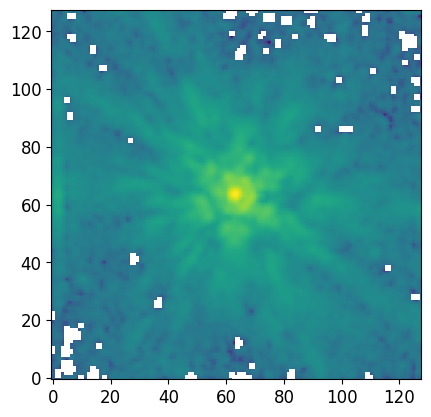

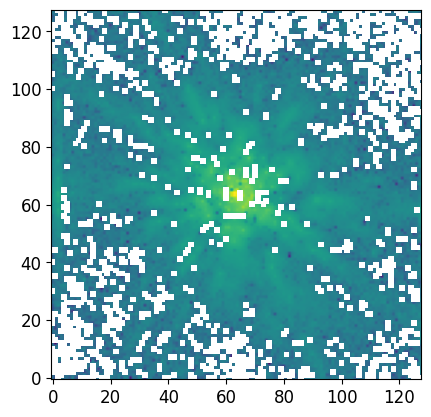

In [15]:
full_psf = model.get_full_psf(**kwargs_final)
narrow_psf = model.get_narrow_psf(**kwargs_final)

fig6 = plt.figure()
plt.imshow(np.log10(full_psf), origin='lower')

fig7 = plt.figure()
plt.imshow(np.log10(narrow_psf), origin='lower')

# Example on how to retrieve different elements of the PSF 
n_psf = 2
estimated_full_psf0 = model.model(n_psf, **kwargs_final)

dif = new_data[n_psf,:,:] - estimated_full_psf0
rr = dif / np.sqrt(new_sigma2[n_psf,:,:])
subrr = rr[int(0.8*image_size):, int(0.8*image_size):]

print(np.mean(subrr))
print(np.std(subrr))
print(np.mean(rr))
print(np.std(rr))
print('Overall Reduced Chi2 : ', -2 * loss._log_likelihood_chi2(kwargs_final) / (image_size**2))

fig6.savefig(os.path.join(outpath, 'full_PSF.png'))
fig7.savefig(os.path.join(outpath, 'narrow_PSF.png'))

with open(os.path.join(outpath, 'info.txt'), 'w') as f:
    f.write(f'Mean central :{np.mean(subrr)} \n')
    f.write(f'STD central :{np.std(subrr)} \n')
    f.write(f'Mean all :{np.mean(rr)} \n')
    f.write(f'STD all :{np.std(rr)} \n')
    f.write(f'Overall chi2 :{-2 * loss._log_likelihood_chi2(kwargs_final) / (image_size**2)} \n')


## Save the final model

In [16]:
model.export(outpath, kwargs_final, new_data, new_sigma2, format='fits')